# step1) 데이터셋 구성

## 1-1. 필요 라이브러리 임포트

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

from IPython import display
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.4.1


## 1-2. 데이터 로드
- 이미 3차원이라 따로 reshape 필요없음

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

## 1-3. 학습 데이터 정규화

- 학습에 사용할 이미지는 [-1, 1] 값으로 정규화

In [3]:
train_x = (train_x - 127.5) / 127.5

## 1-4. 미니배치 데이터셋 구성

- BUFFER_SIZE는 학습 데이터셋과 같거나 더 크게 설정해야 효과적

In [4]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [6]:
train_dataset

<BatchDataset shapes: (None, 32, 32, 3), types: tf.float64>

# step2) 생성자 모델 구현

(32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.
noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.
생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.

In [7]:
# 변형 시도 1
# Dense 입력 사이즈와 LeakyReLU alpha=0.2
# 커널 사이즈 4로 스트라이드 2로
def make_generator_model(alpha=0.2):

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(4*4*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # Second: Reshape layer
    model.add(layers.Reshape((4, 4, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [9]:
dirno = 9

In [10]:
generator9 = make_generator_model()
generator9.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4096)              409600    
_________________________________________________________________
batch_normalization_3 (Batch (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 8, 8, 128)         524288    
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)        

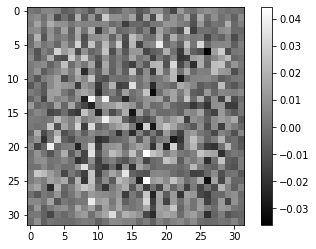

In [11]:
noise = tf.random.normal([1, 100])
generated_image9 = generator9(noise, training=False)
generated_image9.shape
plt.imshow(generated_image9[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

# step3) 판별자 모델 구현

(32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.
위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.

In [13]:
# def make_discriminator_model():

#     # Start
#     model = tf.keras.Sequential()

#     # First: Conv2D Layer
#     model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))

#     # Second: Conv2D Layer
#     model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))

#     # Third: Flatten Layer
#     model.add(layers.Flatten())

#     # Fourth: Dense Layer
#     model.add(layers.Dense(1))

#     return model

In [17]:
def make_discriminator_model(alpha=0.2):

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(layers.Dropout(0.3))

#     # Second: Conv2D Layer
#     model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
#     model.add(layers.LeakyReLU(alpha=alpha))
#     model.add(layers.Dropout(0.3))
    
   # Third: Conv2D Layer
    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(layers.Dropout(0.3))
    
    # Third: Flatten Layer
    model.add(layers.Flatten())
#     model.add(layers.Dropout(0.4))
    
    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [18]:
discriminator9 = make_discriminator_model()

discriminator9.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 16, 16, 64)        3136      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 256)         262400    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 8, 8, 256)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 8, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)            

In [19]:
decision9 = discriminator9(generated_image9, training=False)
decision9

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00167346]], dtype=float32)>

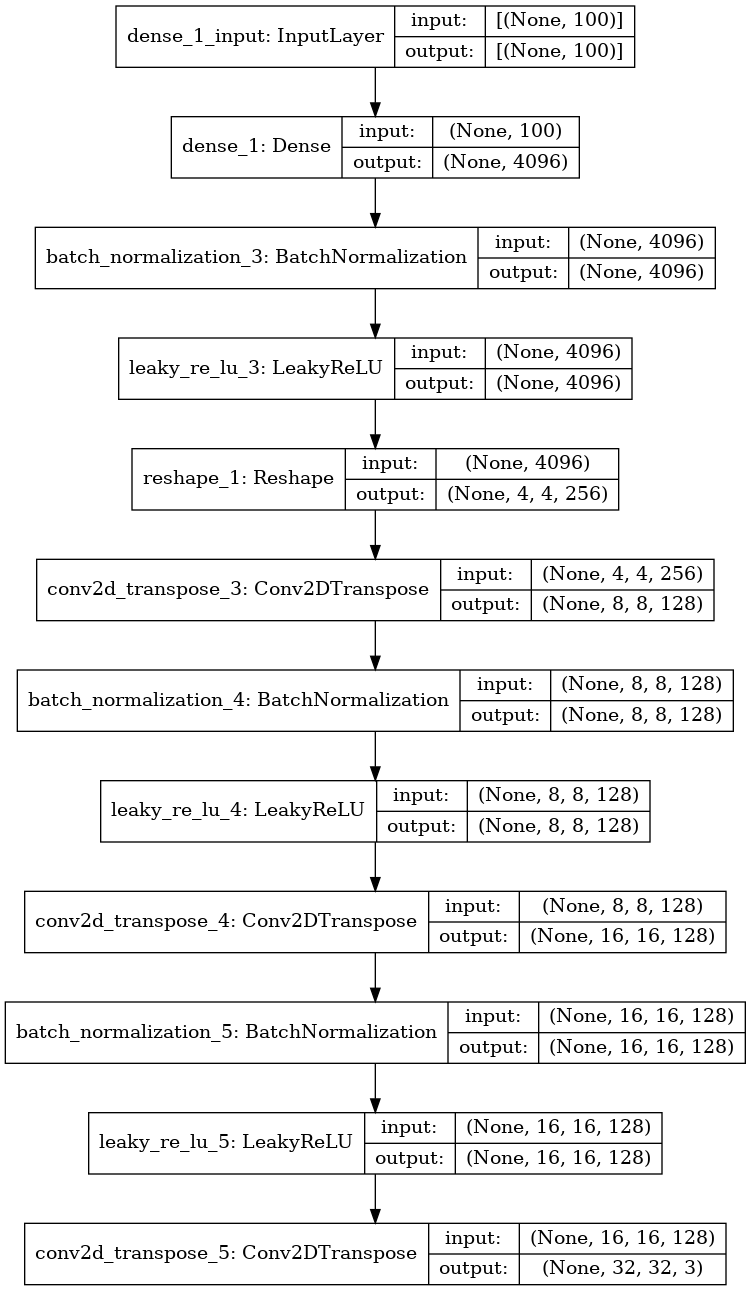

In [15]:
plot_model(generator9, show_shapes=True, to_file=f'generator{dirno}.png')

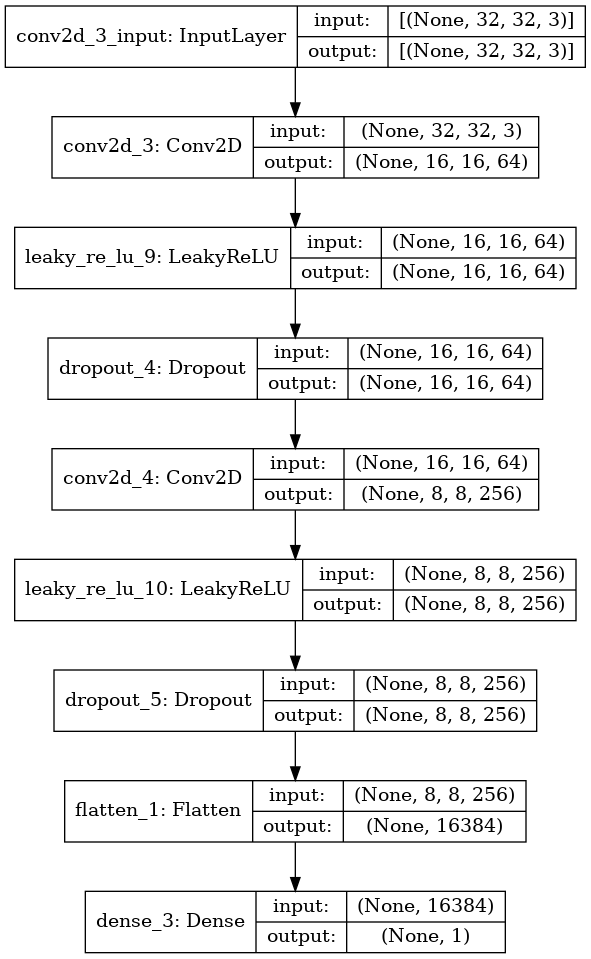

In [20]:
plot_model(discriminator9, show_shapes=True, to_file=f'discriminator{dirno}.png')

# step4) 손실함수, 최적화함수 구현

생성자와 판별자의 손실함수(loss)를 구현해 봅시다.
판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.
생성자와 판별자를 최적화하는 optimizer를 정의합니다.

In [22]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [23]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [24]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [25]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [20]:
# generator_optimizer = tf.keras.optimizers.Adam(1e-4)
# discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [26]:
# 네번째 시도 optimizer 조정
# 아홉번째 시도 optimizer 그대로
generator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

In [26]:
# 네번째 시도 optimizer 조정
# 아홉번째 시도 optimizer 그대로
generator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5, momentum=0.4)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5,  momentum=0.4)

In [27]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

# step5) 훈련과정 기능 함수 구현

## 5-1. 미니배치 실행 함수
- `def train_step(images, gen, dis)` : 미니배치 한 개 훈련 과정

In [28]:
@tf.function
def train_step(images, gen, dis):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = gen(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = dis(images, training=True)
        fake_output = dis(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, gen.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, dis.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, dis.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

## 5-2. 학습 현황 확인하는 샘플 생성 함수
- `def generate_and_save_images(model, epoch, it, sample_seeds, dirno=1)` : 훈련하면서 생성한 이미지를 시각화하는 함수.

In [29]:
def generate_and_save_images(model, epoch, it, sample_seeds, dirno=1):

    predictions = model(sample_seeds, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.array(predictions[i, :, :, :]*127.5 + 127.5).astype('uint8'))
        plt.axis('off')

    # 시각화한 이미지 파일에 저장
    try:
        gif_path = '{}/aiffel/enode13/dcgan_newimage/cifar10/generated_samples{:02d}/'.format(os.getenv('HOME'), dirno)
        if not os.path.exists(gif_path):
            os.makedirs(gif_path)
    except OSError:
        print(f'Error : Cannot creating Directory {gif_path}')
    plt.savefig('{}/aiffel/enode13/dcgan_newimage/cifar10/generated_samples{:02d}/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), dirno, epoch, it))

    plt.show()

## 5-3. 모델 평가지표로 학습 과정 확인 함수
- `def draw_train_history(history, epoch, dirno)` : GAN의 학습 과정을 기록하는 함수
    - 매 step마다 `train_step()` 함수가 반환하는 `gen_loss`, `disc_loss`, `real_accuracy`, `fake_accuracy`를 딕셔너리 키로 삼고 매 학습에서 평가지표 각각의 값을 리스트로 저장.
    - 한 epoch 마다 시각화

In [30]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch, dirno):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    # 시각화한 이미지 파일에 저장
    try:
        history_path = '{}/aiffel/enode13/dcgan_newimage/cifar10/training_history{:02d}/'.format(os.getenv('HOME'), dirno)
        if not os.path.exists(history_path):
            os.makedirs(history_path)
    except OSError:
        print(f'Error : Cannot creating Directory {history_path}')
    plt.savefig('{}/aiffel/enode13/dcgan_newimage/cifar10/training_history{:02d}/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), dirno, epoch))
    plt.show()

## 5-4. 체크포인트
- 학습 결과를 체크포인트로 저장하자.

In [31]:
dirno = 9

In [32]:
checkpoint_dir = os.getenv('HOME')+f'/aiffel/enode13/dcgan_newimage/cifar10/training_checkpoints{dirno}'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator9,
                                 discriminator=discriminator9)

# step6) 학습 과정 진행
- `def make_gif(dirno)` : 학습 과정 동안 생성한 이미지들로 gif 파일을 생성해 학습 진행 과정을 시각화
- `def train(dataset, epochs, save_every, dirno, genno, disno)` : 실제 학습 진행하는 함수. `save_every`에 지정한 epochs 때 마다 저장한다.

학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.
학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출합니다.

In [33]:
def train(dataset, epochs, save_every, dirno, genno, disno):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch, genno, disno)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(genno, epoch+1, it+1, seed, dirno)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(genno, epochs, it, seed, dirno)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch, dirno)

In [34]:
save_every = 5

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 하이퍼 파라미터 튜닝

In [35]:
EPOCHS = 100
# 하이퍼 파라미터 튜닝하고 학습 반복할 때 마다 ++ 할 것

In [36]:
train_dataset

<BatchDataset shapes: (None, 32, 32, 3), types: tf.float64>

# 아홉번째 시도

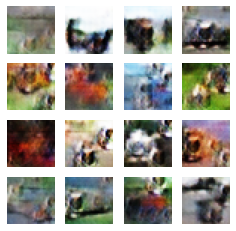

Time for training : 8528 sec


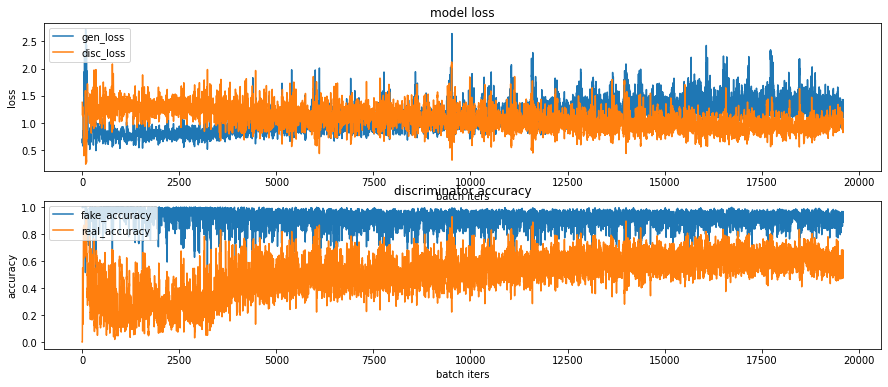

CPU times: user 2h 20min 35s, sys: 1min 26s, total: 2h 22min 2s
Wall time: 2h 22min 9s


In [37]:
%%time
train(train_dataset, EPOCHS, save_every, dirno, generator9, discriminator9)

(참고) 학습 과정 중 학습 epoch를 추가 진행해야 하거나, 학습한 모델을 활용하여 이미지를 생성할 필요가 생깁니다. 그럴 때마다 모델 학습을 처음부터 다시 진행한다면 시간 낭비가 될 것입니다.
우리는 위에서 checkpoint 모듈을 이용해 모델을 저장해 둔 바 있습니다. 이를 이용해 학습해 둔 모델을 로드하면 모델 재학습이 필요 없이 이런 작업을 진행할 수 있습니다.

- 체크포인트를 통해 모델이 로드되었으면 로드된 모델의 파라미터 상태에서 훈련 재개 가능

- 4번째 시도가 괜찮은 것 같아서 계속 학습을 이어가보기로 했다.

In [71]:
checkpoint_dir

'/aiffel/aiffel/enode13/dcgan_newimage/cifar10/training_checkpoints4'

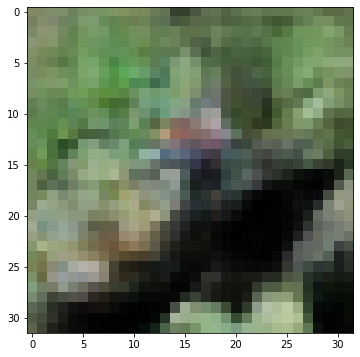

In [72]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [64]:
def make_gif(dirno):
    anim_file = os.getenv('HOME')+f'/aiffel/enode13/dcgan_newimage/cifar10/cifar_dcgan{dirno}.gif'

    with imageio.get_writer(anim_file, mode='I') as writer:
        filenames = glob.glob('{}/aiffel/enode13/dcgan_newimage/cifar10/generated_samples{:02d}/sample*.png'.format(os.getenv('HOME'), dirno))
        filenames = sorted(filenames)
        last = -1
        for i, filename in enumerate(filenames):
            frame = 2*(i**0.5)
            if round(frame) > round(last):
                last = frame
            else:
                continue
            image = imageio.imread(filename)
            writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)

In [102]:
!ls -l ~/aiffel/enode13/dcgan_newimage/cifar10/cifar_dcgan.gif

-rw-r--r-- 1 root root 1272077 Aug 29 18:58 /aiffel/aiffel/enode13/dcgan_newimage/cifar10/cifar_dcgan.gif


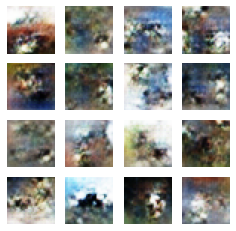

In [110]:
generate_and_save_images(generator, 30, 1, seed)

In [69]:
make_gif(4)

In [67]:
!ls -l ~/aiffel/enode13/dcgan_newimage/cifar10/cifar_dcgan7.gif

-rw-r--r-- 1 root root 800192 Sep  2 04:58 /aiffel/aiffel/enode13/dcgan_newimage/cifar10/cifar_dcgan7.gif


In [74]:
# 최적화 함수만 조절한 후 이어서 학습
generator_optimizer = tf.keras.optimizers.Adam(5e-5, decay=1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(5e-4, decay=1e-5)

In [76]:
dirno = 41

# step7) GAN 훈련과정 개선 (optional)

STEP 6을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석해 봅시다.
모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습 과정 그래프 포함)를 함께 제출합니다.

- [How To Train a GAN](https://github.com/soumith/ganhacks)
- [10 Lessons I Learnd Training GANs](https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628)
- [Tips for Training Stable Generative Adversarial Networks](https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/)
- [Improved Techniques for Training GANs](https://papers.nips.cc/paper/6125-improved-techniques-for-training-gans.pdf)

## 다시 불러서 재학습

In [ ]:
# 가중치 로드
model.load_weights(checkpoint_path)


# 회고

# 루브릭
